<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-this-notebook-does" data-toc-modified-id="What-this-notebook-does-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What this notebook does</a></span></li><li><span><a href="#Usual-Firedrake-preliminaries" data-toc-modified-id="Usual-Firedrake-preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Usual Firedrake preliminaries</a></span></li><li><span><a href="#ODE-data-and-mesh" data-toc-modified-id="ODE-data-and-mesh-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ODE data and mesh</a></span></li><li><span><a href="#Non-homogeneous-boundary-conditions" data-toc-modified-id="Non-homogeneous-boundary-conditions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Non-homogeneous boundary conditions</a></span></li><li><span><a href="#Specifying-left-and-right-boundary-conditions-separately." data-toc-modified-id="Specifying-left-and-right-boundary-conditions-separately.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Specifying left and right boundary conditions separately.</a></span></li><li><span><a href="#Homogeneous-Neumann-Boundary-Conditions" data-toc-modified-id="Homogeneous-Neumann-Boundary-Conditions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Homogeneous Neumann Boundary Conditions</a></span></li><li><span><a href="#Inhomogeneous-Neumann-Boundary-Conditions" data-toc-modified-id="Inhomogeneous-Neumann-Boundary-Conditions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Inhomogeneous Neumann Boundary Conditions</a></span></li><li><span><a href="#What-if-we-have-no-(explicit)-boundary-conditions???" data-toc-modified-id="What-if-we-have-no-(explicit)-boundary-conditions???-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>What if we have no (explicit) boundary conditions???</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

# Example 3: Boundary conditions in 1D in Firedrake

[Niall Madden](https://www.niallmadden.ie/) _Dec 2024_

This notebook discusses how to implement different boundary conditions. 


## What this notebook does 
We solve the ODE 
$$\mathcal{L}(u) := -\varepsilon u'' + r(x)u  = f(x) \text{ on } \Omega:= (0,1),$$
subject to a variety of boundary conditions. Previously, we've studied the case of homogeneous boundary conditions: $u(0)=u(1)=0$. Now we want to consider:
1. Inhomogeneous conditions: $u(x)=g(x)$ for $x \in \Gamma \Omega$
2. Lists of boundary conditions.
3. Neumann conditions.
4. Solving problems that don't have a unique solution.

## Usual Firedrake preliminaries

In [1]:
import os
if "OMP_NUM_THREADS" not in os.environ:
    os.environ["OMP_NUM_THREADS"] = "1"  

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

##  ODE data and mesh
We'll use the same values for $\varepsilon$, $r$ and $f$ in these examples. But the boundary conditions will change. We'll also use the same $N$, mesh, and function space. And, at least initially, the same weak form.

In [3]:
epsilon = 1.0e-1
r = lambda x : exp(-x)
f = lambda x : 2+cos(2*pi*x)

N = 64
mesh1D = UnitIntervalMesh(N)
Ue = FiniteElement("CG", mesh1D.ufl_cell(), 1)
V = FunctionSpace(mesh1D, Ue)
x = SpatialCoordinate(mesh1D)

u = TrialFunction(V)
v = TestFunction(V)
a = epsilon*u.dx(0)*v.dx(0)*dx + r(x[0])*u*v*dx
L = f(x[0])*v*dx   # Note: this may change in examples below

## Non-homogeneous boundary conditions
In this example, we'll take $u(x)=g(x)$ where $g$ is a function we specify. In this case, we set $u(x)=x$ on the boundary.

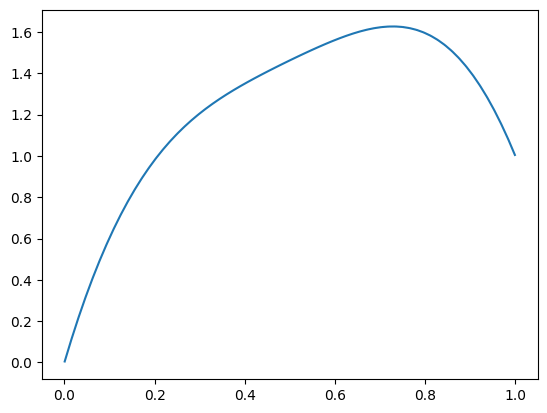

In [4]:
def g(x): return x # boundary conditions
BC1 = DirichletBC(V, g(x[0]), "on_boundary")
    
uN = Function(V)
solve(a == L, uN, bcs=BC1)

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # true

## Specifying left and right boundary conditions separately.
Now we show how to specify different boundary conditions at each boundary, as a list. This could easily be done as in the above example, but builds towards more complex settings, especially in 2D. Also, it uses a poorly documented feature where we exploit that the two boundaries a have their own integer "IDs": $1$ for the left, and $2$ for the right. To know this you'd have to check the docs for both 
`UnitIntervalMesh` and `DirichletBC` at https://www.firedrakeproject.org/firedrake.


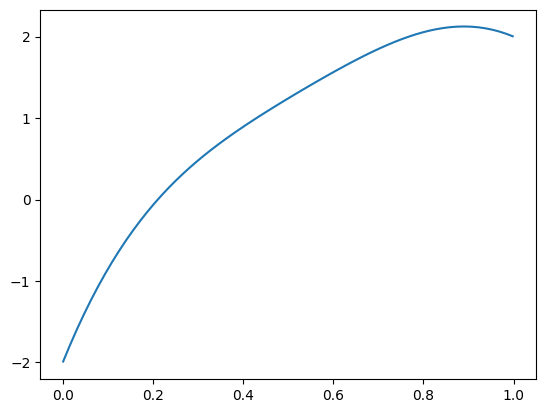

In [5]:
BC1 = DirichletBC(V, -2.0, 1) # left boundary
BC2 = DirichletBC(V, 2.0, 2)  # right left boundary
    
uN = Function(V)
solve(a == L, uN, bcs=[BC1, BC2])

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # true

## Homogeneous Neumann Boundary Conditions
Suppose we want to solve $L(u)=f(x)$ on $(0,1)$, with $u(0)=0$, and $u'(1)=1$. This Neumann (or "natural") boundary condition at $x=1$ is very easy to implement: simply don't specify it! This is because it is implied by the integration-by-parts operation we do in expressing the weak form.

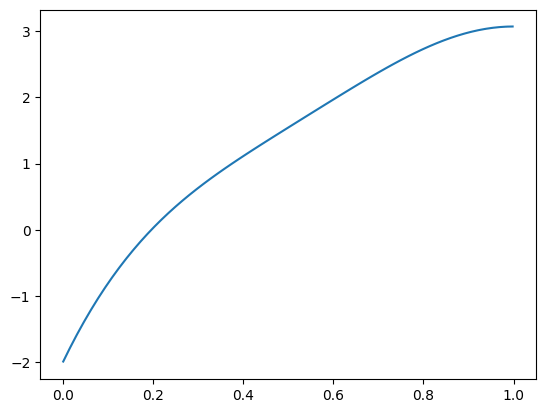

In [6]:
uN = Function(V)
solve(a == L, uN, bcs=BC1) # neglect to do anything at x=1
fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # true

## Inhomogeneous Neumann Boundary Conditions

In this example, we'll again solve $\mathcal{L}(u)=f$, on $(0,1)$, and with $u(0)=0$, but this time with $u'(1)=-5$.


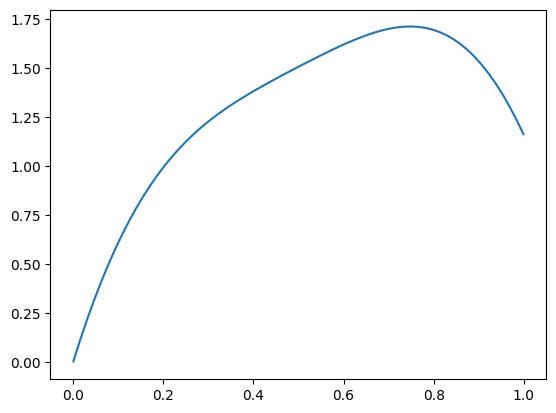

In [7]:
L = f(x[0])*v*dx - epsilon*5*v*ds(2)
uN = Function(V)
solve(a == L, uN, bcs=DirichletBC(V, 0.0, 1))
fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # true

It can be hard to be sure that the Neumann boundary condition is correctly implemented. To check, we'll evaluate the derivative at the boundary. First, we need to interpolate it onto the space.

In [8]:
DuN = Function(V)
DuN.interpolate(uN.dx(0))
print(DuN.at(1.0))

-4.799872728144521


## What if we have no (explicit) boundary conditions???
If we don't give any boundary conditions, this is equivalent to solving the BVP with conditions $u'(0)=u'(1)=0$. That does not have a unique solution: if $u(x)$  is a solution, so too is $u(x)+C$ for any constant $C$. But the solver will still work, assuming (e.g.,) a constant null space.


firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


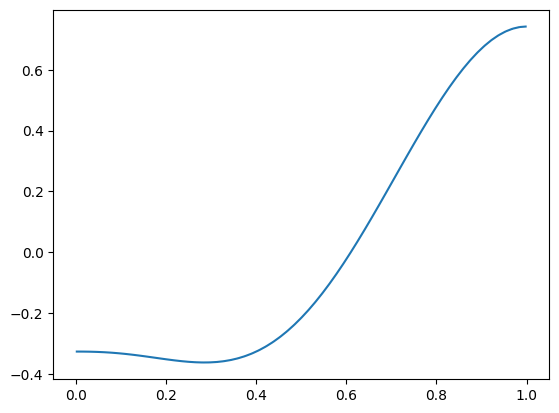

In [9]:
L = f(x[0])*v*dx
uN = Function(V)
nullspace = VectorSpaceBasis(constant=True)
solve(a == L, uN, nullspace=nullspace)
fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # true

##  Exercises

1. Give an explanation of why the approach given above to applying inhomogeneous boundary conditions is correct.
2. Derive the weak form of a problem with a Robin type boundary condition, such as $au(0)-bu'(0)=g_0$, where $a$, $b$ and $g_0$ are given constants.
